# Kaggle Competition: ASHRAE - Great Energy Predictor III

São feitos investimentos significativos para melhorar a eficiência de construções e reduzir seus custos e suas emissões. A questão é: as melhorias estão funcionando? Com o pagamento por desempenho, o proprietário do edifício paga com base na diferença entre o consumo real de energia e o que eles teriam usado sem nenhuma reforma. Os últimos valores têm que vir de um modelo. Os métodos atuais de estimativa são fragmentados e não escalam bem. Alguns assumem um tipo específico de medidor ou não trabalham com diferentes tipos de construção.

Nesta competição, terão de ser desenvolvidos modelos precisos do uso de energia de edifícios medidos nas seguintes áreas: medidores de água resfriada, elétrica, água quente e vapor. Os dados são provenientes de mais de 1.000 edifícios, medidos por hora, em um período de três anos (62 milhões de linhas). Com melhores estimativas desses investimentos em economia de energia, os investidores em larga escala e as instituições financeiras estarão mais inclinadas a investir nessa área, permitindo assim o progresso de edificações eficientes.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_log_error
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import random, datetime, math, gc
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

SEED = 99
random.seed(SEED)
np.random.seed(SEED)

pd.set_option('display.max_columns', None)

# Load

Foram fornecidos 5 arquivos pela competição, os arquivos de treino e teste com Id’s das construções, quando as medições foram feitas e informações sobre o tipo de energia que é consumida. Os arquivos de dados climáticos para os períodos das medições de treino e teste e as informações sobre as construções. Fiz o tratamento dos dados em um notebook anterior para economizar memória, onde realizei a minificação dos dados utilizando técnicas difundidas no Kaggle e a junção de todos os dataframes em dados de treino (aproximadamente 20 milhões de linhas) e teste (aproximadamente 42 milhões de linhas), como saída foram gerados os dois arquivos .pkl que usarei neste notebook.

In [2]:
dftrain = pd.read_pickle('train.pkl')
dftest = pd.read_pickle('test.pkl')
print ('Train: %s , Test %s' % (dftrain.shape, dftest.shape) )

Train: (20216100, 16) , Test (41697600, 16)


In [3]:
dftrain.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


# Preprocessing

Realizo a junção dos dados de treino e teste para ser realizada a feature engineering em todos os dados juntos. Apesar deste método não ser viável em produção em muitos dos casos, no âmbito da competição é eficiente pois gera uma melhora da métrica de avaliação final.

In [4]:
dffe = pd.concat([dftrain,dftest], axis =0, ignore_index=True, sort=False)
print('Shape :',dffe.shape)

Shape : (61913700, 17)


Preencho os valores nulos com 0 e -999

In [5]:
dffe['floor_count'] = dffe['floor_count'].fillna(0).astype(np.int8)
dffe['year_built'] = dffe['year_built'].fillna(-999).astype(np.int16)

# Feature engineering

Nesta fase desenvolvi features referentes ao tempo para contribuir com a detecção de sazonalidade pelo modelo. Também foi adicionado um dataset intrínseco do Pandas referente a feriados americanos que podem contribuir com o consumo de energia das edificações.

In [6]:
dffe['timestamp'] = pd.to_datetime(dffe['timestamp'])

In [7]:
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

In [8]:
dffe['DT_MO'] = dffe['timestamp'].dt.month.astype(np.int8)
dffe['DT_WY'] = dffe['timestamp'].dt.weekofyear.astype(np.int8)
dffe['DT_DY'] = dffe['timestamp'].dt.dayofyear.astype(np.int16)
dffe['is_holiday'] = (dffe['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
dffe['DT_H'] = dffe['timestamp'].dt.hour.astype(np.int8)
dffe['DT_day_week'] = dffe['timestamp'].dt.dayofweek.astype(np.int8)
dffe['DT_day_month'] = dffe['timestamp'].dt.day.astype(np.int8)
dffe['DT_week_month'] = dffe['timestamp'].dt.day/7
dffe['DT_week_month'] = dffe['DT_week_month'].apply(lambda x: math.ceil(x)).astype(np.int8)

transformei a variável target tirando o seu logaritmo, para ter uma distribuição mais próxima da normal.

In [9]:
dffe['meter_reading'] = np.log1p(dffe['meter_reading'])

Deletei as colunas que não serão utilizadas pelo modelo.

In [10]:
dffe.drop(['timestamp','row_id'],axis=1,inplace=True)

#### Encoding

Transformei as colunas que são categóricas no tipo “category” para o Lgbm lidar melhor com estas colunas.

In [11]:
for col in dffe.columns[dffe.dtypes == 'object']:
    le = LabelEncoder()
    le.fit(dffe[col])
    dffe[col] = le.transform(dffe[col])

In [12]:
category = ['meter','primary_use','site_id','building_id']
for col in category :
    dffe[col] = dffe[col].astype('category')

# Validation

A validação foi feita replicando da melhor maneira possível a situação encontrada na competição. Na competição há 1 ano de dados de treino e 2 anos de dados de teste. Então eu utilizei uma técnica de holdout que funciona melhor para time series, dividi os dados que estão ordenados pelo tempo nos primeiros 1/3 para treino e os 2/3 finais para validação. As previsões foram realizadas nestes dados de treino através do metodo de validação cruzada KFold e os resultados comparados com os dados de validação do holdout. Neste setup foram feitos todos os testes de feature engineering adicionando uma feature por vez e observando se a métrica de avaliação do modelo RMSLE melhora.

In [13]:
df_val_train = dffe[:int(dftrain.shape[0]*0.33)]
df_val_test  = dffe[int(dftrain.shape[0]*0.33):dftrain.shape[0]]
print('Shape treino: {:} | Shape teste: {:}'.format(df_val_train.shape, df_val_test.shape))
X_val_train = df_val_train.drop(['meter_reading'], axis = 1)
y_val_train  = df_val_train.meter_reading

Shape treino: (6671313, 23) | Shape teste: (13544787, 23)


In [14]:
lgb_params = {
                    'objective':'regression',
                    'metric':'rmse',
                    'n_jobs':-1,
                    'learning_rate':0.25,
                    'num_leaves': 40,
                    'max_depth':-1,
                    'subsample':0.85,
                    'n_estimators':200,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

Utilizo 2 folds, para replicar o método da predição que demonstrou melhor desempenho até o momento com k=2.

In [15]:
K = 2
folds = KFold(K, shuffle=True, random_state = SEED)
finalpred_validation = np.zeros(df_val_test.shape[0])
for fold , (train_index,test_index) in enumerate(folds.split(X_val_train, y_val_train)):
    print('Fold:',fold+1)
          
    X_traincv, X_testcv = X_val_train.iloc[train_index], X_val_train.iloc[test_index]
    y_traincv, y_testcv = y_val_train.iloc[train_index], y_val_train.iloc[test_index]
    
    train_data = lgb.Dataset(X_traincv, y_traincv)
    val_data   = lgb.Dataset(X_testcv, y_testcv)
    
    %time LGBM = lgb.train(lgb_params, train_data, valid_sets=[train_data,val_data], verbose_eval=25)
    %time finalpred_validation += np.expm1(LGBM.predict(df_val_test.drop(['meter_reading'], axis = 1)))
    print()
    
finalpred_validation /= K

Fold: 1
Training until validation scores don't improve for 100 rounds.
[25]	training's rmse: 0.776107	valid_1's rmse: 0.779106
[50]	training's rmse: 0.686892	valid_1's rmse: 0.691865
[75]	training's rmse: 0.650584	valid_1's rmse: 0.657026
[100]	training's rmse: 0.631202	valid_1's rmse: 0.639123
[125]	training's rmse: 0.614153	valid_1's rmse: 0.623334
[150]	training's rmse: 0.600977	valid_1's rmse: 0.611517
[175]	training's rmse: 0.589498	valid_1's rmse: 0.601392
[200]	training's rmse: 0.581707	valid_1's rmse: 0.594634
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.581707	valid_1's rmse: 0.594634
Wall time: 41.4 s
Wall time: 1min 12s

Fold: 2
Training until validation scores don't improve for 100 rounds.
[25]	training's rmse: 0.787624	valid_1's rmse: 0.789413
[50]	training's rmse: 0.694633	valid_1's rmse: 0.697475
[75]	training's rmse: 0.660257	valid_1's rmse: 0.664353
[100]	training's rmse: 0.634509	valid_1's rmse: 0.639488
[125]	training's rmse: 0.616752	vali

Transformo os dados negativos em 0 pois nao há como existir uma medição de consumo de energia negativa, e meço o RMSLE.

In [16]:
finalpred_validation = np.where((finalpred_validation < 0), 0, finalpred_validation)
print("Root mean squared logarithm error: %.2f"
      % np.sqrt(mean_squared_log_error(np.expm1(df_val_test.meter_reading), finalpred_validation)))

Root mean squared logarithm error: 1.68


## Feature importance and Model explainability with SHAP values

Nesta parte busco entender quais as features mais importantes para o modelo gerar os resultados. Também tenho a possibilidade de conseguir explicar como o modelo fez para chegar na previsão para cada linha, o que é muito importante em um cenário de projetos no ambiente de trabalho. Para isso, utilizo a biblioteca [SHAP](https://github.com/slundberg/shap) que é uma abordagem unificada para explicar a saída de qualquer modelo de machine learning. Essa parte tem os valores de previsão em escala logarítmica pois o valor "meter_reading" que é o nosso Y, foi convertido anteriormente para a melhoria do modelo.

In [17]:
explainer = shap.TreeExplainer(LGBM)

In [18]:
shap_values = explainer.shap_values(X_val_train.sample(10000, random_state=99))

Primeiro quero ver quais as variáveis mais significativas para o modelo. Com o próximo plot é possível ver as variáveis mais significativas em ordem decrescente, mostrando que a área da construção e o id da construção são os principais fatores que contribuem para a inferência no modelo. Podemos ver também que ser feriado não faz muita diferença na hora de gerar as previsões.

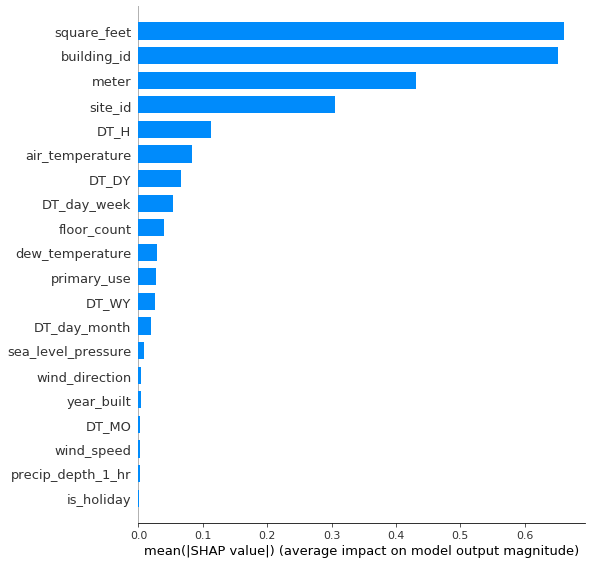

In [19]:
shap.summary_plot(shap_values, X_val_train.sample(10000, random_state=99), plot_type="bar")

Há outro plot muito interessante que podemos fazer com a SHAP que é o summary_plot. Esse plot pode ser feito com todos os pontos dos dados de treino, eu decidi fazer com uma amostra de 10000 pontos. É possível observar muitas informações gerais de como o modelo funciona deste plot. 

Cada ponto no plot é um ponto dos dados de treino. A primeira coisa que podemos perceber é que ele assim como o plot anterior também mostra as variáveis mais significativas em ordem decrescente. A posição de cada ponto no eixo horizontal mostra se o efeito daquele valor é associado a uma previsão maior ou menor, inclusive mostrando no eixo X o quanto há de impacto no valor previsto pelo modelo. A cor mostra se essa variável tem o valor alto (em vermelho) ou baixo (em azul) para essa observação.

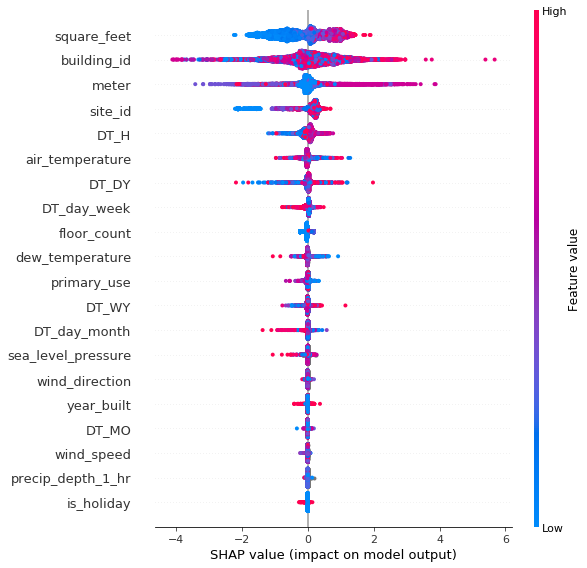

In [20]:
shap.summary_plot(shap_values, X_val_train.sample(10000, random_state=99))

Observando o plot, podemos perceber que a variável square_feet divide bem os dados e tem uma correlação positiva com o valor previsto. Quanto maior o valor de square_feet(vermelho), mais energia aquela construção gasta (localização do ponto mais para a direita). Outra variável também interessante , é o dia (DT_day_month) que tem um padrão parecido com o square_feet porém correlacionado negativamente, valores de dias maiores tem um gasto de energia menor, indicando que no começo do mês se gasta menor energia nessas construções.

Também podemos olhar para cada variável individualmente com um dependence_plot.

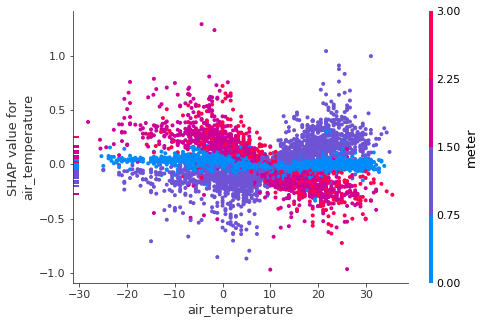

In [21]:
shap.dependence_plot('air_temperature', shap_values, X_val_train.sample(10000, random_state=99))

Eu escolhi fazer este plot com a variável temperatura do ar. Na esquerda é mostrado o quanto houve de impacto na saída do modelo, no eixo X podemos ver qual o valor da temperatura do ar e na direita a função encontra automaticamente a variável que mais interage com a variável escolhida e mostra através das cores o seu valor. O plot da temperatura do ar é muito interessante pois mostra que quanto menor a temperatura do ar, mais é gasto com 2 (vapor) e 3 (água quente), com 0 (eletricidade) não muda e com 1 (água gelada) quanto maior a temperatura do ar mais é gasto.

Também podemos ver qual a importância de cada feature e como o modelo tomou a decisão para gerar a sua previsão em cada linha do nosso dataframe de treino individualmente com o force_plot.

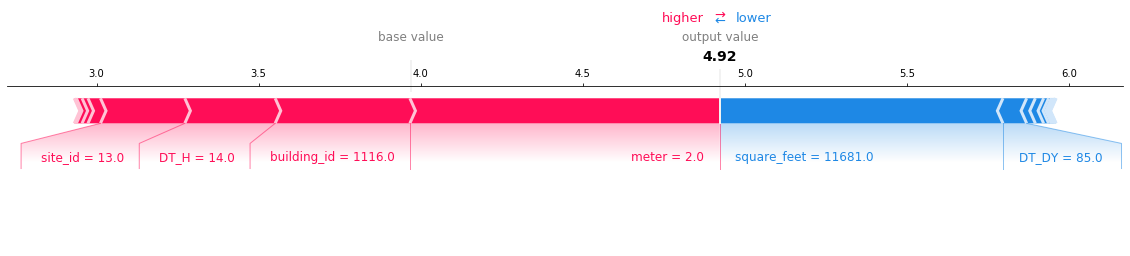

In [22]:
shap.force_plot(explainer.expected_value, shap_values[0], X_val_train.sample(10000, random_state=99).iloc[0], matplotlib=True)

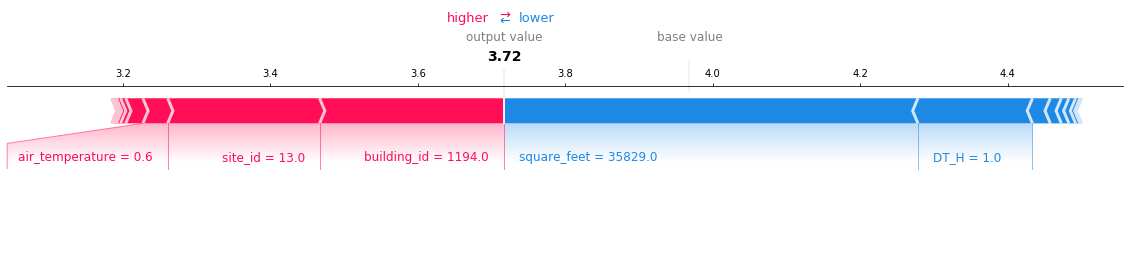

In [24]:
shap.force_plot(explainer.expected_value, shap_values[5], X_val_train.sample(10000, random_state=99).iloc[5], matplotlib=True)

Fiz 2 gráficos para 2 valores individuais do nosso dataframe. Este gráfico mostra o valor previsto pelo modelo (output value), mostra o valor médio das previsões (base value) e as setas coloridas são as features que aumentam a previsão mostradas em vermelho, e as que diminuem a previsão mostradas em azul. O tamanho das setas é o quanto aquela feature influenciou para a previsão do gasto de energia pelo modelo, também é mostrado qual o valor daquela feature para essa linha. Neste último plot podemos ver que o valor de square_feet de 35829 influenciou fortemente para a diminuição da previsão feita pelo modelo.

In [25]:
del df_val_train, df_val_test, X_val_train, y_val_train
gc.collect()

36634

# Modeling

A modelagem foi realizada em um setup de validação cruzada KFold com 2 folds, pois neste momento se mostrou melhor do que com outros testes com 5 ou mais folds. O modelo faz a validação com a fold que ficou de fora em cada iteração, usando esta mesma fold para parar o treino em caso de não haver mais melhora da métrica de avaliação. Inicialmente separo de volta os dados em treino e teste a partir do dataframe que foi realizado a feature engineering. Depois divido nas features preditoras(X_train) e o target(Y_train) e faço as previsões.

#### Split

In [26]:
dftrain = dffe[:dftrain.shape[0]]
dftest  = dffe[dftrain.shape[0]:].drop(['meter_reading'], axis=1)
print('Shape treino: {:} | Shape teste: {:}'.format(dftrain.shape, dftest.shape))

Shape treino: (20216100, 23) | Shape teste: (41697600, 22)


In [27]:
X_train = dftrain.drop(['meter_reading'], axis = 1)
y_train  = dftrain.meter_reading

In [28]:
del dffe
gc.collect()

67

###### Model

In [29]:
lgb_params = {
                    'objective':'regression',
                    'metric':'rmse',
                    'n_jobs':-1,
                    'learning_rate':0.25,
                    'num_leaves': 40,
                    'max_depth':-1,
                    'subsample':0.85,
                    'n_estimators':500,
                    'seed': SEED,
                    'early_stopping_rounds':100,
                } 

In [30]:
K = 2
folds = KFold(K, shuffle=True, random_state = SEED)
finalpred = np.zeros(dftest.shape[0])
for fold , (train_index,test_index) in enumerate(folds.split(X_train, y_train)):
    print('Fold:',fold+1)
          
    X_traincv, X_testcv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_traincv, y_testcv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    train_data = lgb.Dataset(X_traincv, y_traincv)
    val_data   = lgb.Dataset(X_testcv, y_testcv)
    
    %time LGBM = lgb.train(lgb_params, train_data, valid_sets= [train_data,val_data], verbose_eval=250)
    %time finalpred += np.expm1(LGBM.predict(dftest))
    print()
    
finalpred /= K

Fold: 1
Training until validation scores don't improve for 100 rounds.
[250]	training's rmse: 0.698892	valid_1's rmse: 0.703651
[500]	training's rmse: 0.636441	valid_1's rmse: 0.644282
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.636441	valid_1's rmse: 0.644282
Wall time: 5min 7s
Wall time: 9min 56s

Fold: 2
Training until validation scores don't improve for 100 rounds.
[250]	training's rmse: 0.701967	valid_1's rmse: 0.706875
[500]	training's rmse: 0.637543	valid_1's rmse: 0.645575
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.637543	valid_1's rmse: 0.645575
Wall time: 5min 5s
Wall time: 9min 44s



As previsões são a média do exponencial (para transformar de volta na escala original) da previsão de cada fold.

# Submission

Leio o arquivo de submissão da competição com os id's das linhas, e adiciono as previsões. Salvo o arquivo em formato comprimido para economizar espaço no disco e para o upload no site do Kaggle ser mais rápido.

In [31]:
submission = pd.read_csv('sample_submission.csv')
submission['meter_reading'] = finalpred
submission['meter_reading'] = np.where((submission['meter_reading'] < 0), 0, submission['meter_reading'])
submission.to_csv('solution.csv.gz',index=False,compression='gzip')
submission.head()

,row_id,meter_reading
0,0,0.026356
1,1,0.130647
2,2,0.000000
3,3,0.126255
4,4,0.458051


Atualmente esta solução tem uma RMSLE de 1.14 no [leaderboard](https://www.kaggle.com/c/ashrae-energy-prediction/leaderboard) do Kaggle (Nome do time "rossinEndrew"). A melhor solução publicada até o momento tem um RMSLE de 1.05.